# ReAct Agent VS Custom Agent

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1KUCIBFtDytL2gFgyFC46t_Yjp3jDjdUF/view?usp=sharing)

[Corrective-RAG (CRAG)](https://arxiv.org/abs/2401.15884) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents. 

Here's we're going to show two different way to implement Corrective-RAG: 

(1) We will implement this as a [ReAct agent](https://react-lm.github.io/). 

(2) We will implement this agent as a custom / user-defined control flow in LangGraph. 

Then, we will show how to test these agents. 

(1) We'll build an [evaluation set of question-answer pairs for RAG in LangSmith](https://docs.smith.langchain.com/tutorials/Developers/agents#eval). 

(2) We'll evaluate end-to-end performance of our agents along with the specific reasoning trace of each one.

This notebook will reference ideas from [these slides](https://docs.google.com/presentation/d/1QWkXi4DYjfw94eHcy9RMLqpQdJtS2C_kx_u7wAUvlZE/edit?usp=sharing).

![](../static/1.png)

## Environment

We'll start with [OpenAI](https://python.langchain.com/v0.2/docs/integrations/chat/openai/) as our LLM, but this can be easily swapped. 

We'll use [Tavily](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.

We'll use a vectorstore with [OpenAI embeddings](https://python.langchain.com/v0.2/docs/integrations/text_embedding/openai/#embed-documents).

We'll use [LangSmith](https://docs.smith.langchain.com/) for tracing and evaluation.

In [ ]:
import os

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access environment variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

# Check if required environment variables are set
required_vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "TAVILY_API_KEY"]
for var in required_vars:
    if not os.getenv(var):
        raise EnvironmentError(f"{var} is not set in the .env file")

print("Environment variables loaded successfully.")

## LLM

Select the LLM to use for both of our agents.

This can be easily swapped with [other models that support tool use](https://python.langchain.com/v0.2/docs/integrations/chat/)!

In [ ]:
from langchain_openai import ChatOpenAI

model_name = "gpt-4o"
metadata = "CRAG, gpt-4o"
llm = ChatOpenAI(model_name=model_name, temperature=0)

## ReAct Agent

First, we'll define our [ReAct agent](https://python.langchain.com/v0.2/docs/tutorials/agents/) for corrective RAG!

LLM powered autonomous agents [use three things to accomplish tasks](https://lilianweng.github.io/posts/2023-06-23-agent/):

- `Tools`: Actions to gather external information that is missing from the model weights
- `Planning`: Often this is self-criticism and self-reflection over past actions
- `Memory`: Ability to recall information (e.g., from the user or from past actions)

[ReAct](https://arxiv.org/abs/2210.03629) is popular that incorporates explicit steps for LLM to:

- `Action`: Choose an action (e.g., often a tool)
- `Observation`: Observe the outputs of the action
- `Think`: Reason about the next step

These steps follow a loop until the agent stops calling tools and decides to return a final answer.

Let's set up our ReAct agent by first defining a few tools.

![](../static/2.png)

### Tools

First, we'll index 3 blog posts and store them in a vectorstore and define [this as a tool](https://python.langchain.com/v0.2/docs/concepts/#tools).


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.tools import tool
from langchain_openai import OpenAIEmbeddings

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=250, chunk_overlap=0)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Add the document chunks to the "vector store" using OpenAIEmbeddings
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever(k=4)

USER_AGENT environment variable not set, consider setting it to identify your requests.


When we define this as a `tool` and bind it too the LLM, then the LLM can:

* Choose to call this tool
* Formulate the payload needed to run the tool

![](../static/3.png)

In [ ]:
# Define a tool, which we will connect to our agent
@tool
def retrieve_documents(query: str) -> list:
    """Retrieve documents from the vector store based on the query."""
    return retriever.invoke(query)

We'll create a tool that instructs our agent to reflect on the retrieved documents.


In [ ]:
@tool
def grade_document_retrieval(step_by_step_reasoning: str, score: int) -> str:
    """You are a teacher grading a quiz. You will be given:
    1/ a QUESTION
    2/ a set of comma separated FACTS provided by the student

    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the FACTS are relevant to the QUESTION.
    A score of 0 means that NONE of the FACTS are relevant to the QUESTION.

    If your score is 1: then call a tool to generate the answer, generate_answer
    If your score is 0: then call a tool to perform web search, web_search."""

    if score == 1:
        return "Docs are relevant. Generate the answer to the question."
    return "Docs are not relevant. Use web search to find more documents."

We'll create a tool for web search using Tavily.


In [ ]:
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()


@tool
def web_search(query: str) -> str:
    """Run web search on the question."""
    web_results = web_search_tool.invoke({"query": query})
    return [Document(page_content=d["content"], metadata={"url": d["url"]}) for d in web_results]

Finally, we'll create a tool that instructs our agent to produce the final distillated answer.

In [ ]:
@tool
def generate_answer(answer: str) -> str:
    """You are an assistant for question-answering tasks.
    Use the retrieved documents to answer the user question.
    If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise"""
    return f"Here is the answer to the user question: {answer}"

Now, we store these in a tools list, which we will bind to our LLM.


In [ ]:
tools = [retrieve_documents, grade_document_retrieval, web_search, generate_answer]

### Planning

Now, we'll define an LLM assistant for our agent, which can use the tools we defined above.


In [ ]:
from typing import Annotated, List

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph.message import AnyMessage, add_messages
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


class Assistant:
    def __init__(self, runnable: Runnable):
        """
        Initialize the Assistant with a runnable object.

        Args:
            runnable (Runnable): The runnable instance to invoke.
        """
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        """
        Call method to invoke the LLM and handle its responses.
        Re-prompt the assistant if the response is not a tool call or meaningful text.

        Args:
            state (State): The current state containing messages.
            config (RunnableConfig): The configuration for the runnable.

        Returns:
            dict: The final state containing the updated messages.
        """
        while True:
            result = self.runnable.invoke(state)  # Invoke the LLM
            if not result.tool_calls and (not result.content or isinstance(result.content, list) and not result.content[0].get("text")):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Create the primary assistant prompt template
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            " You are a helpful assistant tasked with answering user questions using the provided vector store. " " Use the provided vector store to retrieve documents. Then grade them to ensure they are relevant before answering the question. ",
        ),
        ("placeholder", "{messages}"),
    ]
)

# Prompt our LLM and bind tools
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

### Memory

Finally, we'll using [LangGraph](https://langchain-ai.github.io/langgraph/) to orchestrate our agent.

LangGraph is a library for building agents, which allows us to define 2 nodes:

- `Assistant`, which will contain the `assistant_runnable` defined above
- `Tool`, which will call the tool when the assistant instructs and return the tool outputs to our assistant
 
LangGraph allows us to define state, which will serve as short-term memory over the lifetime of our agent.

First, there are some utilities that we'll use to help define the graph. 

In [ ]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)], exception_key="error")


def handle_tool_error(state: State) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

Now, we'll define our graph.

We'll simply cycle between 2 nodes: 

* Our `assistant` node reasons and plans which tool to use
* Our `tool` node that executes the tool

It will continue as long as our `assistant` is making a tool call. 

This shows the general flow:

![](../static/4.png)

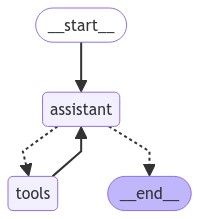

In [ ]:
from IPython.display import Image, display
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import tools_condition

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = SqliteSaver.from_conn_string(":memory:")
react_graph = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Finally, we can call our agent.


In [ ]:
import uuid


def predict_react_agent_answer(example: dict):
    """Use this for answer evaluation"""

    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    messages = react_graph.invoke({"messages": ("user", example["input"])}, config)
    return {"response": messages["messages"][-1].content, "messages": messages}


example = {"input": "What are the types of agent memory?"}
response = predict_react_agent_answer(example)

In [ ]:
def find_tool_calls_react(messages):
    """
    Find all tool calls in the messages returned from the ReAct agent
    """
    tool_calls = [tc["name"] for m in messages["messages"] for tc in getattr(m, "tool_calls", [])]
    return tool_calls


find_tool_calls_react(response["messages"])

['retrieve_documents', 'grade_document_retrieval', 'generate_answer']

With LangSmith set, we can see the trace:

https://smith.langchain.com/public/4510c99f-abdf-4fdd-aebf-270f4e49e02f/r

We can follow the tool calls to clearly see the reasoning trace:

* Our agent first calls `retrieve_documents` tool to get documents.
 
* Then, it calls `grade_document_retrieval` tool and deems the documents to be relevant.
 
* Finally, it calls `generate_answer` to produce the final answer.